In [1]:
import torch

device = torch.device("mps")
device

device(type='mps')

In [2]:
# common.py

import time
import functools
import socket
import struct

col_dic = {"d": 30, "r": 31, "g": 32, "y": 33, "b": 34, "p": 35, "c": 36, "w": 37}


def string_decorator(basic: str, /, col: str = "w", b: bool = False) -> str:
    return f"\033[{'1;' if b else '0;'}{col_dic[col]}m{basic}\033[0m"


import logging

logging.basicConfig(
    level=logging.INFO,
    format=string_decorator("[%(asctime)s %(levelname)s]", "c") + " %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)


def call_log(text: str = ""):
    def decorator(func):
        @functools.wraps(func)
        def wrapper(*args, **kw):
            if len(text) == 0 or text.isspace():
                print(string_decorator(f"[Call Function {func.__name__}()]", "g", True))
            else:
                print(
                    string_decorator(
                        f"[Call Function {func.__name__}()]: {text}", "g", True
                    )
                )
            return func(*args, **kw)

        return wrapper

    return decorator


def time_log(func):
    @functools.wraps(func)
    def wrapper(*args, **kw):
        _time_str = time.time()
        res = func(*args, **kw)
        _time_stp = time.time()
        print(
            string_decorator(
                f"[Function {func.__name__}() Finished] cost time: {_time_stp - _time_str:6.3f} s.",
                "p",
                True,
            )
        )
        return res

    return wrapper


def addr_num2str(num_addr: int) -> str:
    return socket.inet_ntoa(struct.pack("I", socket.htonl(num_addr)))


def addr_str2num(str_addr: str) -> int:
    return socket.ntohl(struct.unpack("I", socket.inet_aton(str(str_addr)))[0])

In [3]:
# data.py

import os
import random
import math
from typing import List, Tuple

import torch

T_MAX = 100
ETH_MTU = 1500


@time_log
def load_data(
    data_tag: str,
    data_target: str,
    shuffle_seed=None,
    fig_path=None,
    train_ratio=0.80,
    segment_len=1000,
    time_base=1e-6,
) -> Tuple[
    torch.FloatTensor,
    torch.FloatTensor,
    torch.FloatTensor,
    torch.FloatTensor,
    List[List[int]],
    List[List[int]],
    List[List[int]],
    List[List[int]],
]:

    if not os.path.exists(data_target):
        exit(-1)

    logging.info(f"Read dataset from {data_target}")
    tim_vec, len_vec, label_vec = [], [], []
    with open(data_target, "r") as f:
        for ll in f.readlines():
            [a, b, c] = list(map(float, ll.split()))
            tim_vec.append(math.floor(a * (1 / time_base)))
            len_vec.append(min(b, ETH_MTU) / ETH_MTU)
            label_vec.append(int(c))

    iat_vec = [0]
    start = tim_vec[0]
    for i in range(1, len(tim_vec)):
        iat_vec.append(min(max(tim_vec[i] - start, 0), T_MAX))
        start = max(start, tim_vec[i])

    feature_vec = []
    real_label_vec = []
    num_packet_vec = []
    num_attack_vec = []
    index = 0
    while index < len(iat_vec):
        time_var = iat_vec[index]
        # Add time
        feature_vec.append(-time_var / T_MAX)
        real_label_vec.append(label_vec[index])

        num_packet_vec.append(0)
        num_attack_vec.append(int(label_vec[index]))

        # Add packet length
        feature_vec.append(len_vec[index])
        real_label_vec.append(label_vec[index])

        num_packet_vec.append(1)
        num_attack_vec.append(int(label_vec[index]))

        index += 1

    seg_feature_vec, seg_label_vec = [], []
    seg_num_vec, seg_attack_num_vec = [], []
    for i in range(0, len(feature_vec), segment_len):
        if i + segment_len >= len(feature_vec):
            continue
        seg_feature_vec.append(feature_vec[i : i + segment_len])
        seg_label_vec.append(real_label_vec[i : i + segment_len])
        seg_num_vec.append(num_packet_vec[i : i + segment_len])
        seg_attack_num_vec.append(num_attack_vec[i : i + segment_len])

    if shuffle_seed is not None:
        random.seed(shuffle_seed)
        _shu_ls = list(
            zip(seg_feature_vec, seg_label_vec, seg_num_vec, seg_attack_num_vec)
        )
        random.shuffle(_shu_ls)
        seg_feature_vec, seg_label_vec, seg_num_vec, seg_attack_num_vec = (
            [x[0] for x in _shu_ls],
            [x[1] for x in _shu_ls],
            [x[2] for x in _shu_ls],
            [x[3] for x in _shu_ls],
        )

    train_test_line = int(train_ratio * len(seg_feature_vec))
    train_data = seg_feature_vec[:train_test_line]
    train_label = seg_label_vec[:train_test_line]
    test_data = seg_feature_vec[train_test_line:]
    test_label = seg_label_vec[train_test_line:]

    train_num = seg_num_vec[:train_test_line]
    test_num = seg_num_vec[train_test_line:]
    train_atc_num = seg_attack_num_vec[:train_test_line]
    test_atc_num = seg_attack_num_vec[train_test_line:]

    train_data = torch.FloatTensor(train_data).unsqueeze(1)
    train_label = torch.FloatTensor(train_label).unsqueeze(1)
    test_data = torch.FloatTensor(test_data).unsqueeze(1)
    test_label = torch.FloatTensor(test_label).unsqueeze(1)

    logging.info(
        f"[{data_tag}] Attack Frames: {label_vec.count(True)}, Benign Frames: {len(label_vec) - label_vec.count(True)}."
    )
    logging.info(
        f"[{data_tag}] Train Records: {train_label.size(0)}, Test Records: {test_label.size(0)}"
    )

    return (
        train_data,
        train_label,
        test_data,
        test_label,
        train_num,
        test_num,
        train_atc_num,
        test_atc_num,
    )

In [4]:
data_hehe = load_data("Whisper_SYNDOS", "dataset/Whisper_SYNDOS.txt")

[2025-03-19 17:03:36 INFO] Read dataset from dataset/Whisper_SYNDOS.txt
[2025-03-19 17:03:49 INFO] [Whisper_SYNDOS] Attack Frames: 255940, Benign Frames: 12951978.
[2025-03-19 17:03:49 INFO] [Whisper_SYNDOS] Train Records: 21132, Test Records: 5283


[Function load_data() Finished] cost time: 13.419 s.


In [5]:
data_hehe[0].shape, data_hehe[1].shape, data_hehe[2].shape, data_hehe[3].shape

(torch.Size([21132, 1, 1000]),
 torch.Size([21132, 1, 1000]),
 torch.Size([5283, 1, 1000]),
 torch.Size([5283, 1, 1000]))

In [6]:
# loss.py

import torch
import torch.nn.functional as F


def dice_loss(prediction, target, smooth=1.0):

    i_, t_ = prediction.view(-1), target.view(-1)
    inter = (i_ * t_).sum()

    return 1 - ((2.0 * inter + smooth) / (i_.sum() + t_.sum() + smooth))


def calc_loss(prediction, target, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(prediction, target)
    prediction = torch.sigmoid(prediction)

    dice = dice_loss(prediction, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    return loss

In [7]:
# model.py

import torch
import torch.nn as nn


class conv_block(nn.Module):

    def __init__(self, in_ch, out_ch):
        super(conv_block, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class up_conv(nn.Module):

    def __init__(self, in_ch, out_ch):
        super(up_conv, self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv1d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm1d(out_ch),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        x = self.up(x)
        return x


class Exosphere(nn.Module):

    def __init__(self, in_ch=3, out_ch=1):
        super(Exosphere, self).__init__()

        n1 = 64
        filters = [n1, n1 * 2, n1 * 4]

        self.Maxpool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.Maxpool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.Conv1 = conv_block(in_ch, filters[0])
        self.Conv2 = conv_block(filters[0], filters[1])
        self.Conv3 = conv_block(filters[1], filters[2])

        self.Up3 = up_conv(filters[2], filters[1])
        self.Up_conv3 = conv_block(filters[2], filters[1])

        self.Up2 = up_conv(filters[1], filters[0])
        self.Up_conv2 = conv_block(filters[1], filters[0])

        self.Conv = nn.Conv1d(filters[0], out_ch, kernel_size=1, stride=1, padding=0)

    def forward(self, x):

        e1 = self.Conv1(x)

        e2 = self.Maxpool1(e1)
        e2 = self.Conv2(e2)

        e3 = self.Maxpool2(e2)
        e3 = self.Conv3(e3)

        d3 = self.Up3(e3)
        d3 = torch.cat((e2, d3), dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((e1, d2), dim=1)
        d2 = self.Up_conv2(d2)

        out = self.Conv(d2)

        return out

In [8]:
# train.py

from typing import List
import torch
import math

import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve,
    auc,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    matthews_corrcoef,
    fbeta_score,
)


mtx = List[List[int]]


@time_log
def train_test(
    data_tag: str,
    log_path: str,
    fig_path: str,
    trainD: torch.FloatTensor,
    trainL: torch.FloatTensor,
    testD: torch.FloatTensor,
    testL: torch.FloatTensor,
    trainN: mtx,
    testN: mtx,
    trainA: mtx,
    testA: mtx,
    gpu_id: int,
    waterline: float,
    lr=0.001,
    batch_size=4,
    num_epoch=15,
):

    logging.info(f"[{data_tag}] is started.")

    fout = open(log_path, "w", buffering=1)
    exosphere = Exosphere(in_ch=1, out_ch=1)

    opt = torch.optim.Adam(exosphere.parameters(), lr=lr)

    exosphere.to(device)
    trainD.to(device)
    trainL.to(device)
    testD.to(device)
    testL.to(device)

    print(
        "Total Parameters:",
        sum([p.nelement() for p in exosphere.parameters()]),
        file=fout,
        flush=True,
    )

    for e in range(num_epoch):
        train_loss = 0.0
        test_loss = 0.0

        exosphere.train()
        num_train = 0
        for i in range(0, trainD.size(0), batch_size):
            if i + batch_size >= trainD.size(0):
                continue

            x = trainD[i : i + batch_size].to(device)
            y = trainL[i : i + batch_size].to(device)
            num_train += batch_size

            opt.zero_grad()
            y_pred = exosphere(x)
            lossT = calc_loss(y_pred, y)

            train_loss += lossT.item() * x.size(0)
            lossT.backward()
            opt.step()

        exosphere.eval()
        torch.no_grad()

        pred_res = []
        label_res = []
        num_res = []
        num_atc_res = []

        num_test = 0
        sum_test_time = 0

        test_batch_size = batch_size * 20
        for i in range(0, testD.size(0), test_batch_size):
            if i + test_batch_size >= testD.size(0):
                continue

            x = testD[i : i + test_batch_size].to(device)
            y = testL[i : i + test_batch_size].to(device)
            num_test += test_batch_size

            start_test = time.time()
            y_pred = exosphere(x)
            end_test = time.time()
            sum_test_time += end_test - start_test
            lossL = calc_loss(y_pred, y)

            test_loss += lossL.item() * x.size(0)
            pred_res.extend(y_pred.view(-1).tolist())
            label_res.extend(y.view(-1).tolist())

            for x in range(i, i + test_batch_size):
                num_res.extend(testN[x])
                num_atc_res.extend(testA[x])

        train_loss /= num_train
        test_loss /= num_test

        assert len(num_atc_res) == len(label_res)
        assert len(num_res) == len(pred_res)

        true_label, true_pred = [], []
        for i in range(len(label_res)):
            if num_res[i] == 0:
                continue
            else:
                true_pred.extend([pred_res[i]] * num_res[i])
                true_label.extend(
                    [1] * num_atc_res[i] + [0] * (num_res[i] - num_atc_res[i])
                )

        fpr, tpr, _ = roc_curve(true_label, true_pred)
        roc_auc = auc(fpr, tpr)
        judge = [1 if sc > waterline else 0 for sc in true_pred]
        f1 = f1_score(true_label, judge, average="macro")
        f2 = fbeta_score(true_label, judge, average="macro", beta=2)
        per = precision_score(true_label, judge, average="macro")
        rec = recall_score(true_label, judge, average="macro")
        acc = accuracy_score(true_label, judge)
        mcc = matthews_corrcoef(true_label, judge)
        fp_v, tp_v, _ = roc_curve(true_label, judge)
        if len(tp_v) != 3 or len(fp_v) != 3:
            logging.warn("Incorrect value for metrics.")
            continue

        def cal_eer(fpr, tpr):
            deta = 1
            err = 0
            for a, b in zip(fpr, tpr):
                d = math.fabs((1 - a) - b)
                if d < deta:
                    deta = d
                    err = a
            return err

        eer = cal_eer(fpr, tpr)

        packet_per_frame = testD.size(2)
        print(
            f"Epoch: {e:2d}, train loss: {train_loss:7.4f}, test loss: {test_loss:7.4f}, "
            f"AUC: {roc_auc:7.4f}, F1: {f1:7.4f}, Percision: {per:7.4f}, Recall: {rec:7.4f}, F2: {f2:7.4f}, "
            f"FPR: {fp_v[1]:7.4f}, TPR: {tp_v[1]:7.4f}, EER: {eer:7.4f}, MCC: {mcc:7.4f}, ACC: {acc:7.4f}, "
            f"Test Time: {sum_test_time:7.4f} s, Test Speed: {(num_test*packet_per_frame)/sum_test_time:7.2f} PPS.",
            file=fout,
            flush=True,
        )

        # Save the distribution of scores
        benign_score = [
            x[1] for x in filter(lambda x: not x[0], list(zip(true_label, true_pred)))
        ]
        attack_score = [
            x[1] for x in filter(lambda x: x[0], list(zip(true_label, true_pred)))
        ]

        fig = plt.figure(figsize=(10, 10 * 0.618), constrained_layout=True)
        ax = fig.subplots(1, 1)

        ax.hist(
            benign_score,
            1000,
            density=True,
            histtype="step",
            cumulative=True,
            label="Benign",
            color="royalblue",
        )
        ax.hist(
            attack_score,
            1000,
            density=True,
            histtype="step",
            cumulative=True,
            label="Attack",
            color="firebrick",
        )
        ax.vlines(
            waterline, 0, 1.05, lw=1, color="grey", linestyles="--", label="Waterline"
        )
        ax.legend(loc="right")
        ax.set_xlabel("Score")
        ax.set_ylabel("CDF")
        ax.set_title(f"Detection Accuracy: {data_tag}")

        save_addr = f"{fig_path}/{data_tag}_result.png"
        fig.savefig(save_addr, dpi=600, format="png")
        plt.cla()

In [9]:
# main.py

from typing import Dict

import torch

import json
import os
import multiprocessing
import random
import argparse
import numpy as np


seed = 777
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)


def train_task(
    data_tag,
    data_path,
    log_path,
    fig_path,
    gpu_id,
    waterline,
    train_test_params,
    data_set_params,
):

    dataset = load_data(
        data_tag, data_path, shuffle_seed=seed, fig_path=fig_path, **data_set_params
    )
    train_test(
        data_tag, log_path, fig_path, *dataset, gpu_id, waterline, **train_test_params
    )


def validate_json_config(jin: Dict) -> bool:
    key_list = [
        "data_path",
        "log_path",
        "fig_path",
        "data_tag",
        "gpu_enable",
        "data_construct_param",
        "train_param",
    ]
    for k in key_list:
        if k not in jin:
            print(f"Key {k} is missed in configuration.")
            return False

    try:
        if not os.path.exists(jin["log_path"]):
            os.makedirs(jin["log_path"])
        if not os.path.exists(jin["fig_path"]):
            os.makedirs(jin["fig_path"])
        if "model_save" in jin and not os.path.exists(jin["model_save"]):
            os.makedirs(jin["model_save"])
    except Exception as e:
        logging.error(f"Exceprtion in create folder" + e)
        return False
    return True


# if __name__ == '__main__':
def run():

    # parser = argparse.ArgumentParser(description='ExoSphere: detect DDoS at L2.')
    # parser.add_argument('-c', '--config', type=str, default='./config.json', help='Configuration file.')
    # args = parser.parse_args()

    config_file = "./config/config_flooding.json"
    with open(config_file, "r") as f:
        jin = json.load(f)
    if not validate_json_config(jin):
        exit(-1)

    # pve = []
    for i, tag in enumerate(jin["data_tag"].keys()):
        # _gpu_id = (
        #     jin["gpu_enable"][i % len(jin["gpu_enable"])]
        #     if len(jin["gpu_enable"]) != 0
        #     else -1
        # )

        # Only use 1 GPU to train sequentially
        _gpu_id = 0
        train_task(
            tag,
            f"{jin['data_path']}/{tag}.txt",
            f"{jin['log_path']}/{tag}.log",
            jin["fig_path"],
            _gpu_id,
            jin["data_tag"][tag],
            jin["train_param"],
            jin["data_construct_param"],
        )

    # [p.start() for p in pve]
    # [p.join() for p in pve]

[2025-03-19 17:03:50 INFO] Read dataset from ./dataset/Whisper_SYNDOS.txt
[2025-03-19 17:04:03 INFO] [Whisper_SYNDOS] Attack Frames: 255940, Benign Frames: 12951978.
[2025-03-19 17:04:03 INFO] [Whisper_SYNDOS] Train Records: 20636, Test Records: 5160
[2025-03-19 17:04:03 INFO] [Whisper_SYNDOS] is started.


[Function load_data() Finished] cost time: 13.481 s.
[Function train_test() Finished] cost time: 760.413 s.


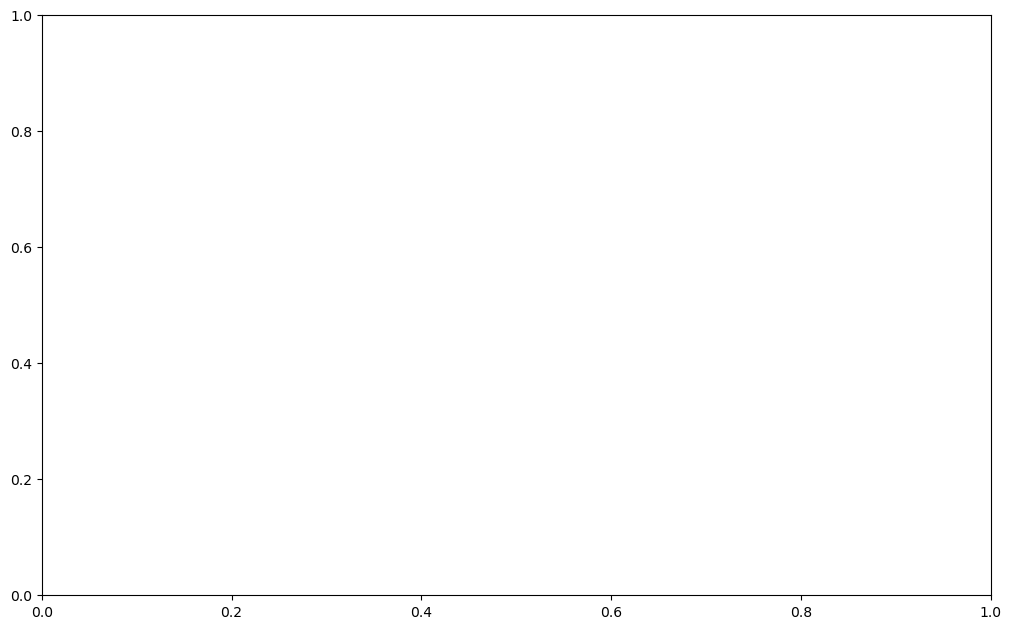

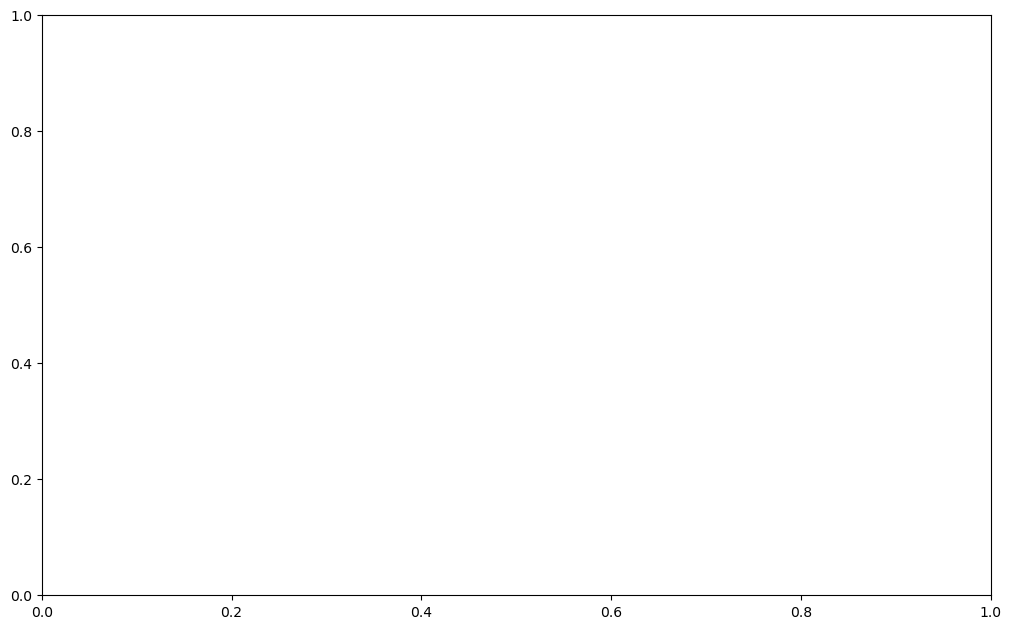

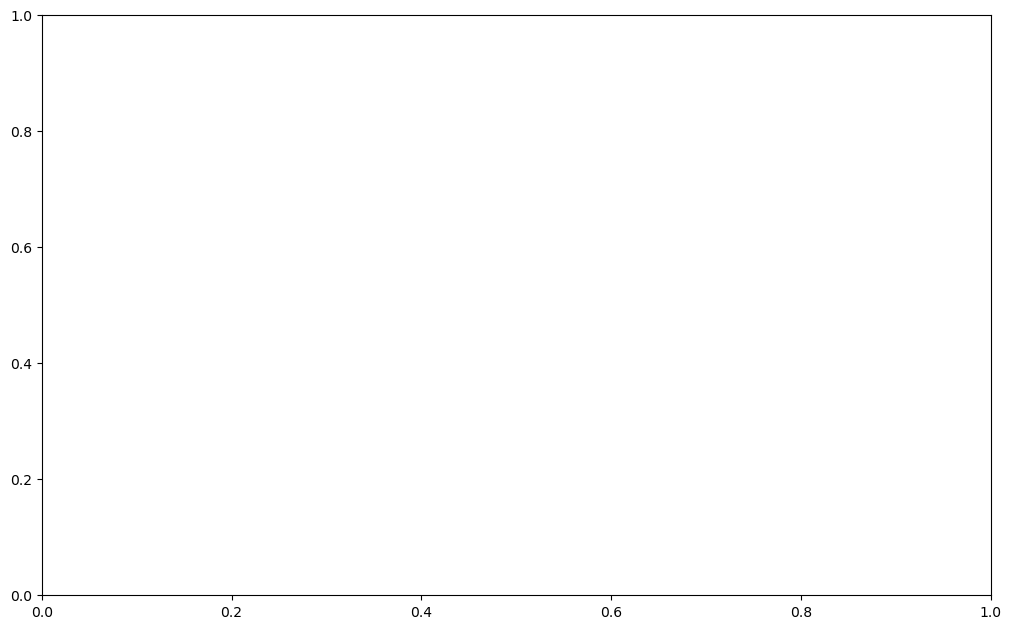

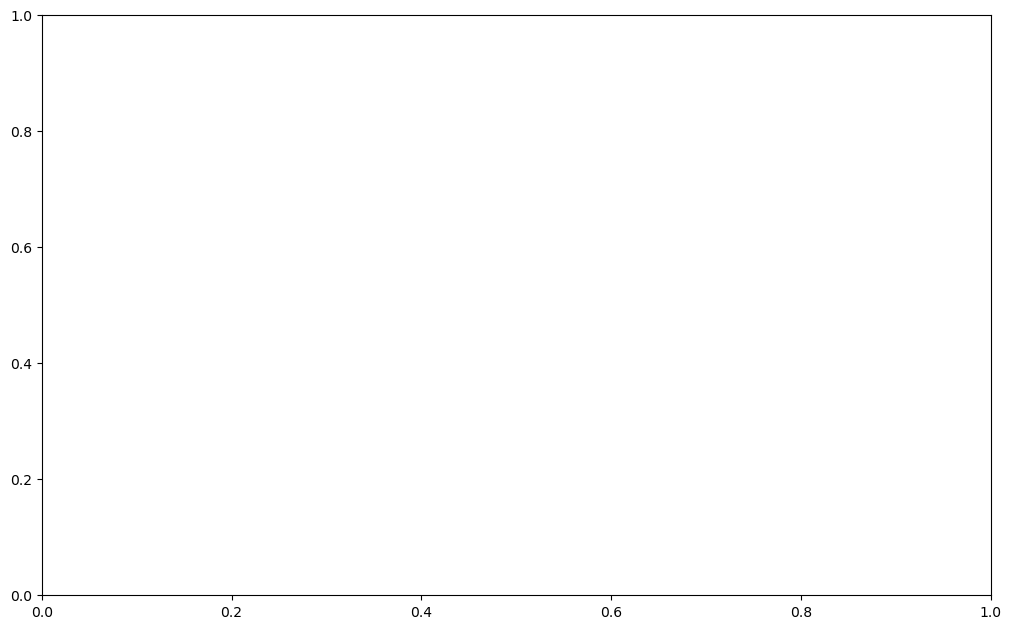

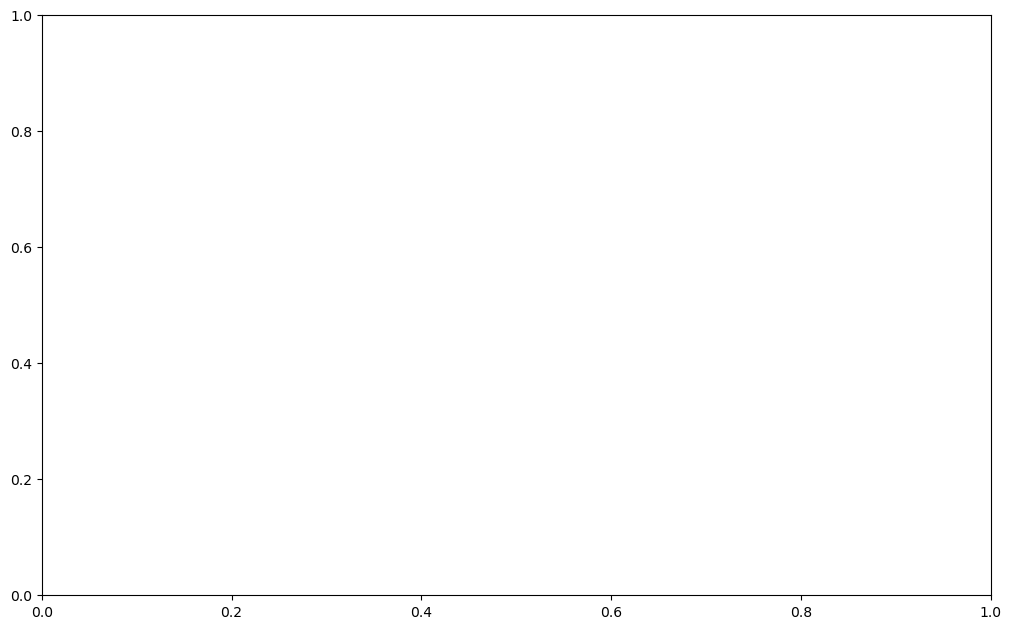

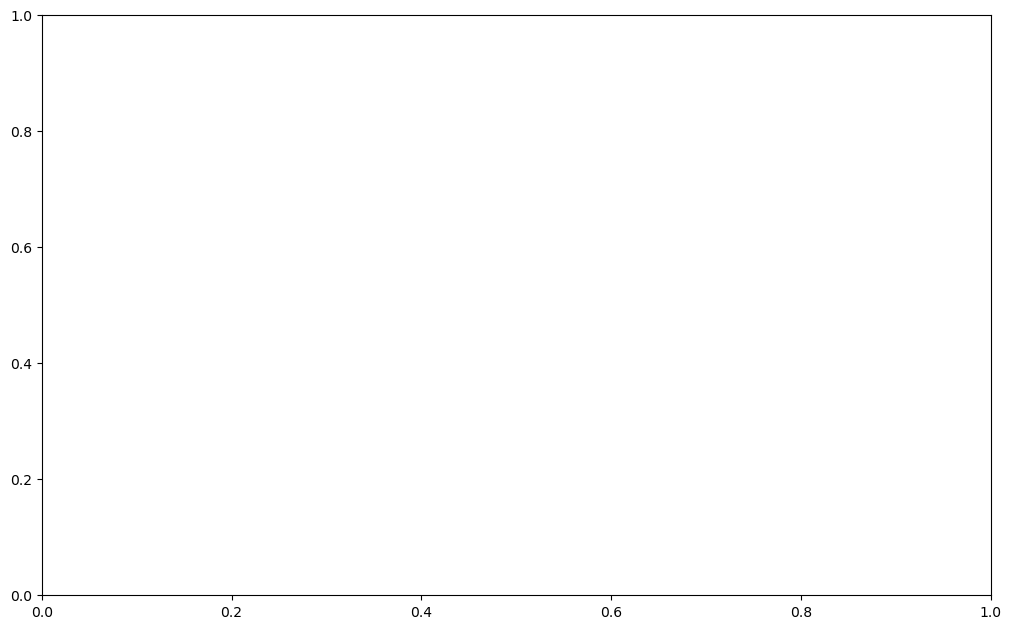

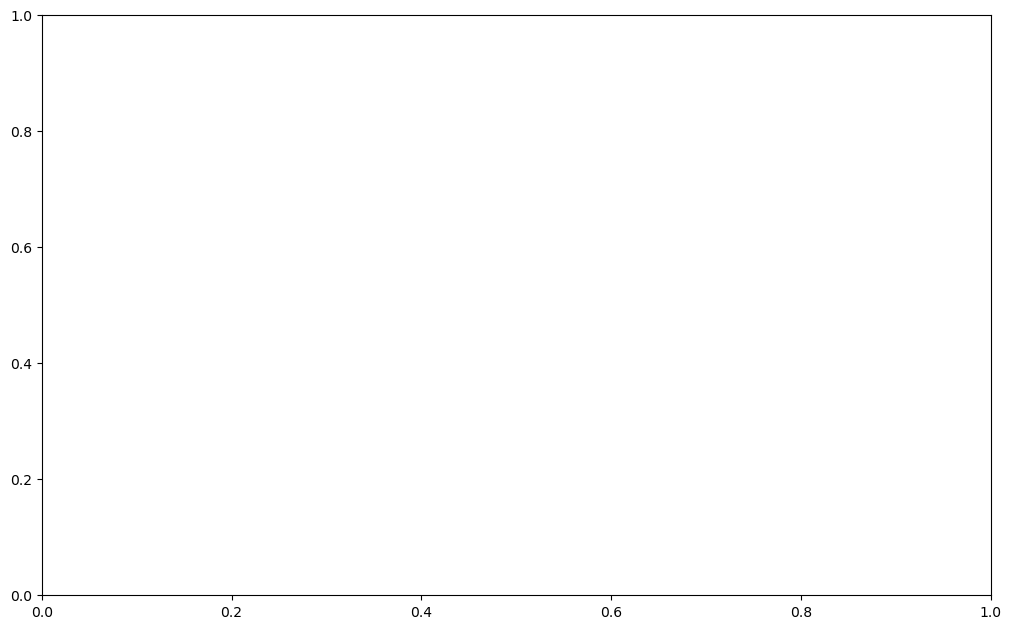

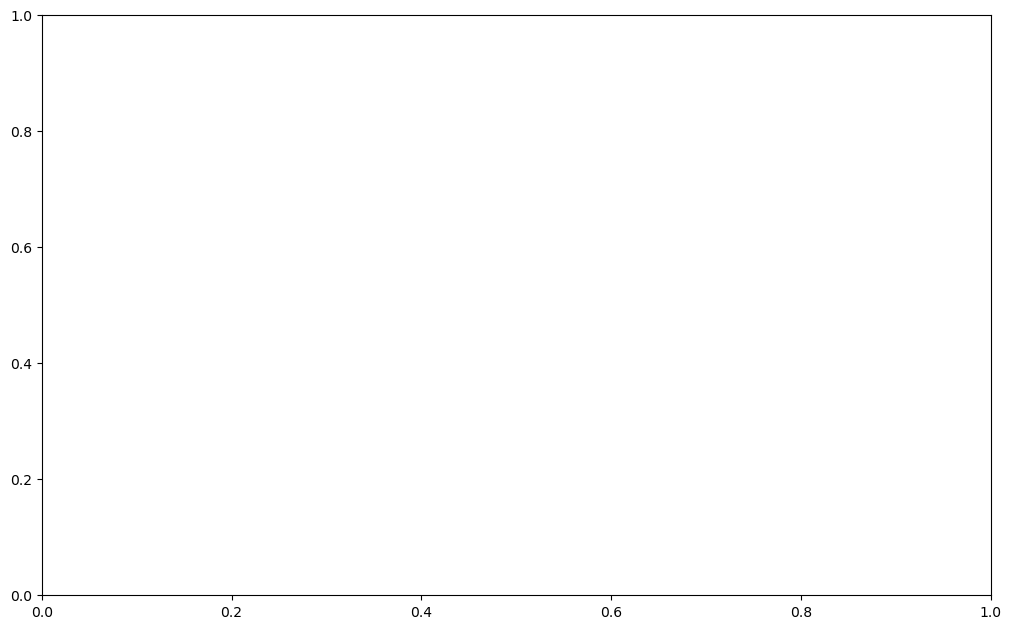

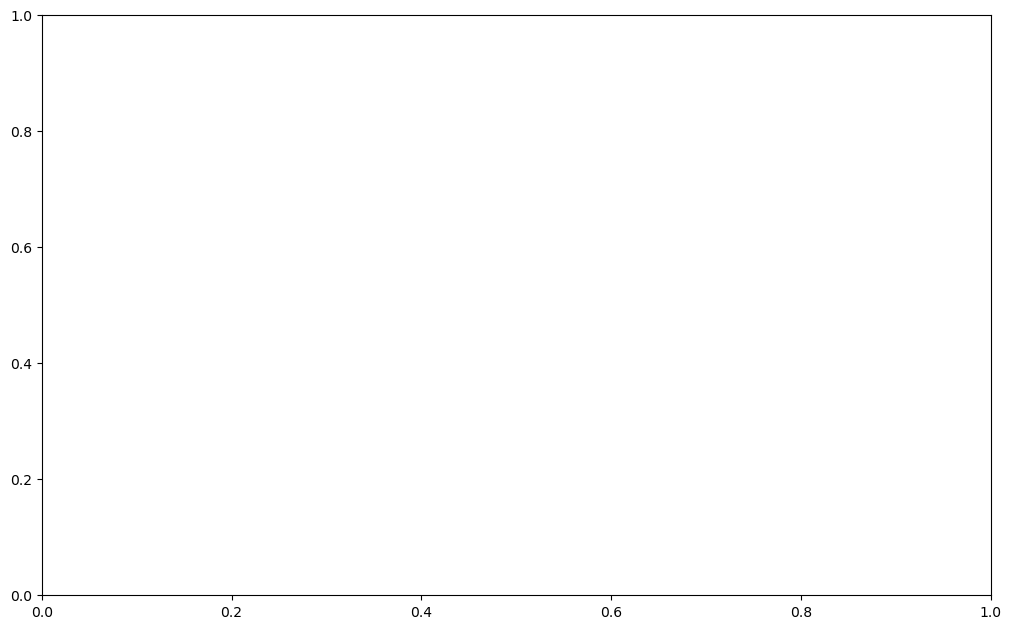

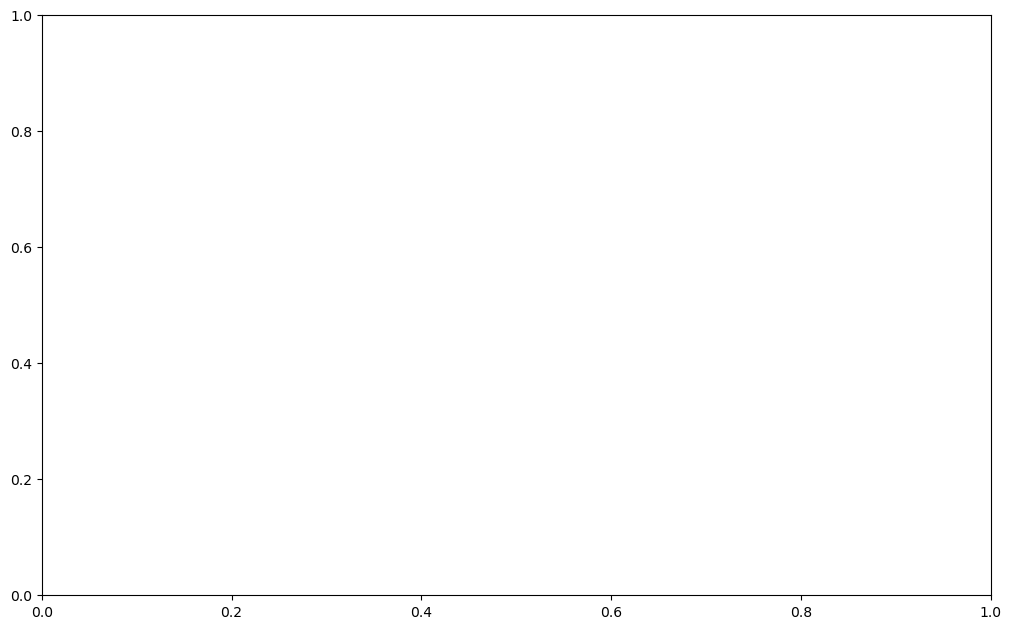

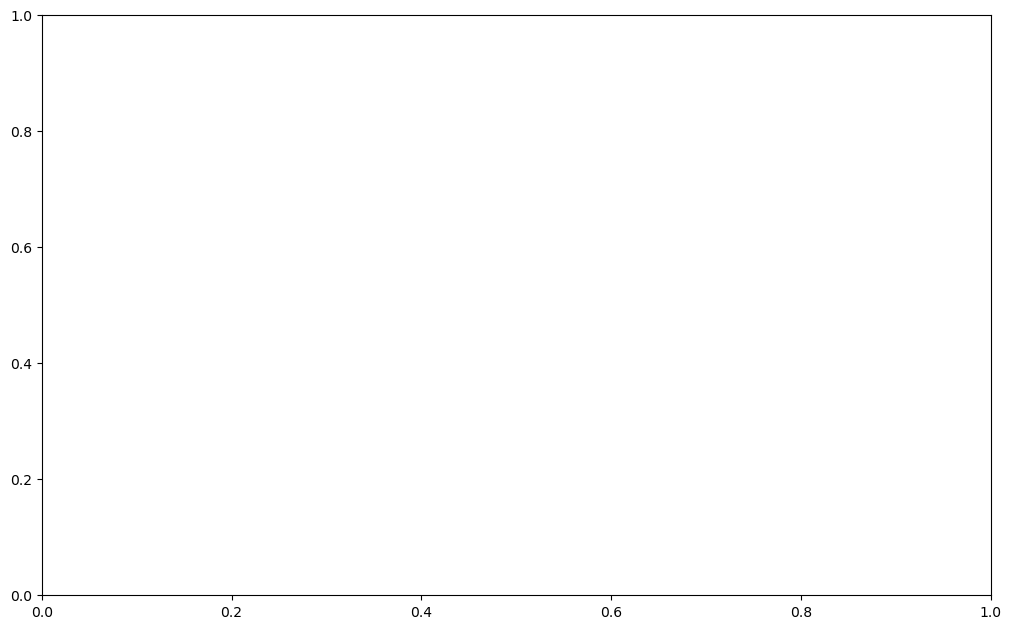

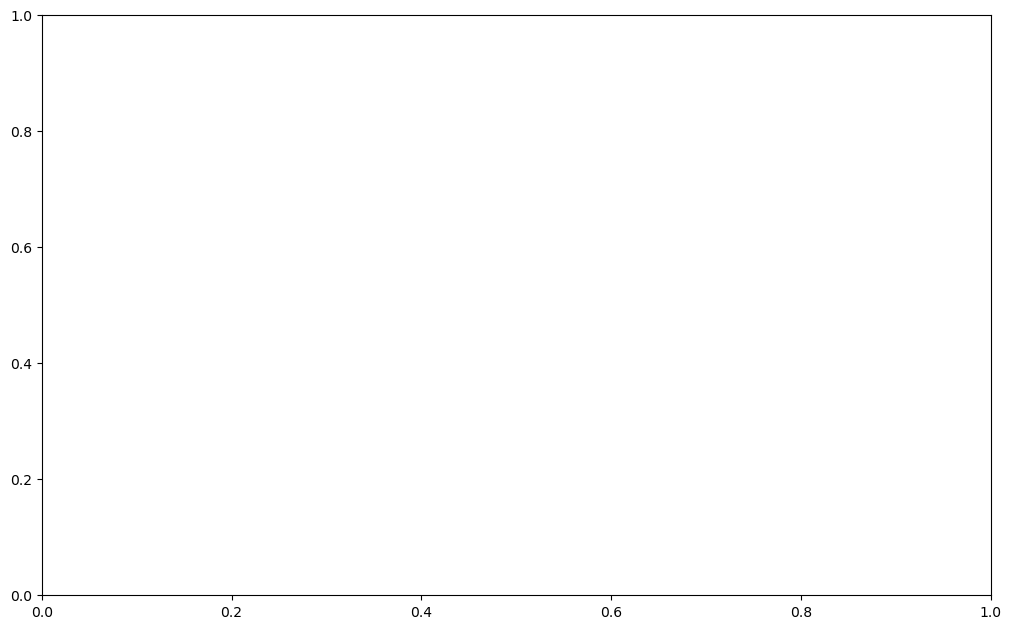

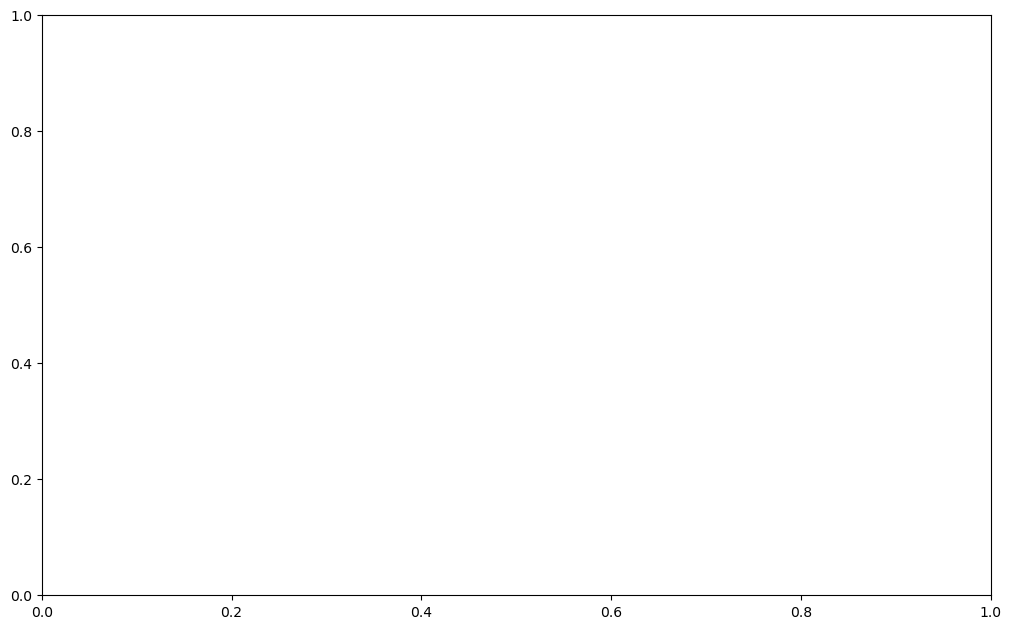

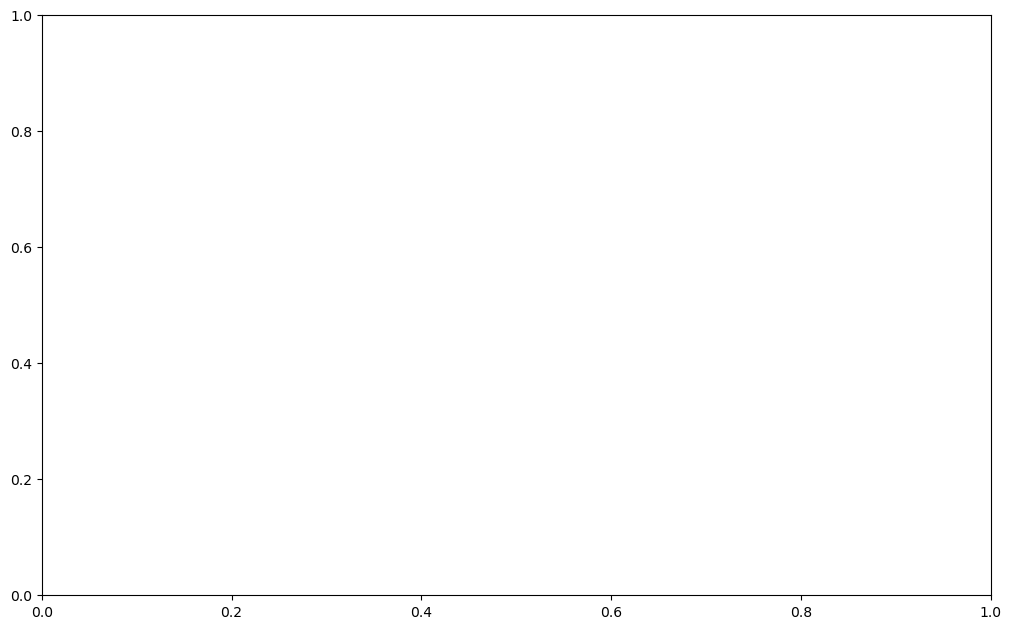

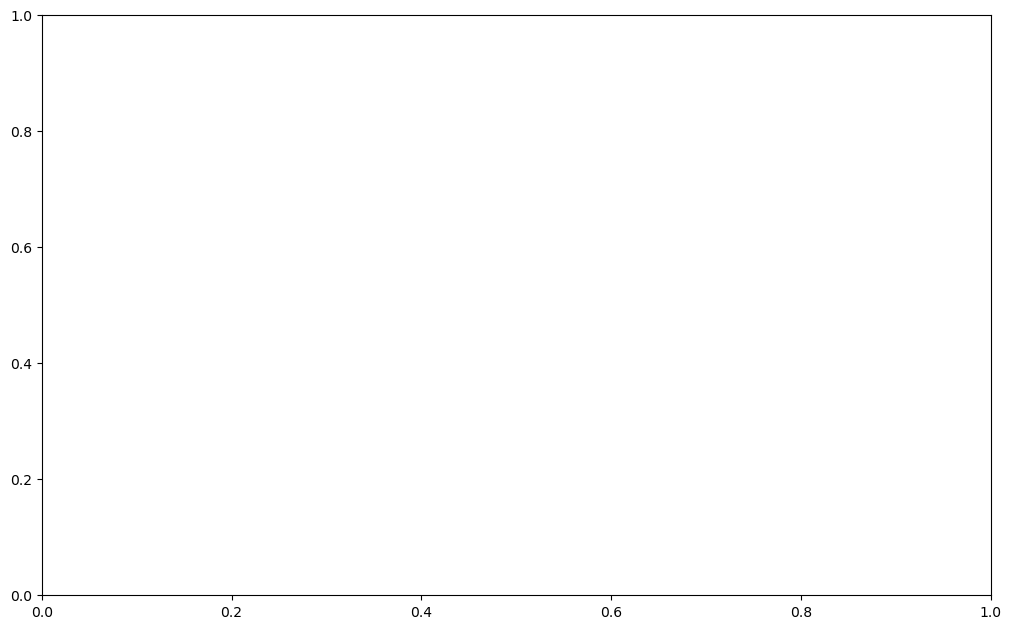

In [10]:
run()

In [12]:
config_file = "./config/config_flooding.json"
with open(config_file, "r") as f:
    jin = json.load(f)
if not validate_json_config(jin):
    exit(-1)

# pve = []
dataset = []  # TESTING ONLY
for i, tag in enumerate(jin["data_tag"].keys()):
    # _gpu_id = (
    #     jin["gpu_enable"][i % len(jin["gpu_enable"])]
    #     if len(jin["gpu_enable"]) != 0
    #     else -1
    # )

    # Only use 1 GPU to train sequentially
    _gpu_id = 0
    config_only = (
        tag,
        f"{jin['data_path']}/{tag}.txt",
        f"{jin['log_path']}/{tag}.log",
        jin["fig_path"],
        _gpu_id,
        jin["data_tag"][tag],
        jin["train_param"],
        jin["data_construct_param"],
    )

    # data_tag,
    # data_path,
    # log_path,
    # fig_path,
    # gpu_id,
    # waterline,
    # train_test_params,
    # data_set_params,

    dataset = load_data(
        config_only[0], config_only[1], shuffle_seed=seed, **jin["data_construct_param"]
    )
    print(dataset[0].shape, dataset[1].shape, dataset[2].shape, dataset[3].shape)

[2025-03-19 17:26:42 INFO] Read dataset from ./dataset/Whisper_SYNDOS.txt
[2025-03-19 17:26:56 INFO] [Whisper_SYNDOS] Attack Frames: 255940, Benign Frames: 12951978.
[2025-03-19 17:26:56 INFO] [Whisper_SYNDOS] Train Records: 20636, Test Records: 5160


[Function load_data() Finished] cost time: 13.542 s.
torch.Size([20636, 1, 1024]) torch.Size([20636, 1, 1024]) torch.Size([5160, 1, 1024]) torch.Size([5160, 1, 1024])
